# Your own time-explicit LCA
This notebooks is your playground! Create your own foreground system, link it to ecoinvent, add temporal information and use `bw_timex` to re-link your processes throughout time to prospective `premise`-databases.

In [1]:
import bw2data as bd
bd.projects.set_current("bw25_ei310_premise")

Create a new foreground process:

In [2]:
if "foreground" in bd.databases:
    del bd.databases["foreground"]
foreground = bd.Database("foreground")
foreground.register()

In [24]:
some_stuff_i_do = foreground.new_node(
    code="some stuff i do",
    name="some stuff i do",
)
some_stuff_i_do.save()
some_stuff_i_do.new_edge(input=some_stuff_i_do, amount=1, type="production").save()

Select some activities from ecoinvent to link to:

In [25]:
house = bd.get_node(database="ecoinvent-3.10-cutoff", name="building construction, multi-storey", location="RER")
work = bd.get_node(database="ecoinvent-3.10-cutoff", name="operation, computer, laptop, active mode", location="CH")
co2 = bd.get_node(database="ecoinvent-3.10-biosphere", name="Carbon dioxide, fossil", categories=("air",))

Create edges and add temporal information:

In [4]:
# A process took place a while ago:

import numpy as np
from bw_temporalis import TemporalDistribution

edge_house_building = some_stuff_i_do.new_edge(
    input=house,
    amount=3, # m3, more like a dog house
    type="technosphere",
)

td_house_building = TemporalDistribution(
    date=np.array([-40], dtype="timedelta64[Y]"),
    amount=np.array([1]),
)

edge_house_building["temporal_distribution"] = td_house_building
edge_house_building.save()

In [5]:
# Something that happens regularly:

from bw_temporalis import easy_timedelta_distribution

WORKYEARS = 30
edge_working = some_stuff_i_do.new_edge(
    input=work,
    amount=2080*WORKYEARS, # h, 
    type="technosphere",
)

td_working = easy_timedelta_distribution(
    start=0,  # (inclusive)
    end=WORKYEARS,  # (inclusive)
    resolution="Y",
    steps=6,  # Includes both start and end
    kind="uniform",  
)

edge_working["temporal_distribution"] = td_working
edge_working.save()

In [6]:
# A specific emission profile

planting_a_tree = foreground.new_node(  
    code="planting a tree",
    name="planting a tree",
    unit="unit",
)
planting_a_tree.save()
planting_a_tree.new_edge(input=planting_a_tree, amount=1, type="production").save()
planting_a_tree.new_edge(input=co2, amount=-1000, type="biosphere").save()

some_stuff_i_do.new_edge(
    input=planting_a_tree,
    amount=1,
    type="technosphere",
).save()

In [7]:
# oops, forgot to save the edge object or working with existing models? 
# there's a utility function to help you out ;)
from bw_timex.utils import add_temporal_distribution_to_exchange

td_co2_uptake_tree = easy_timedelta_distribution(
    start=0,  # (inclusive)
    end=100,  # (inclusive)
    resolution="Y",
    steps=11,  # Includes both start and end
    kind="triangular",  
    param=60,
)

# only works if this is the only edge between these two nodes - otherwise, you need to specify the edge object directly
add_temporal_distribution_to_exchange(
    temporal_distribution=td_co2_uptake_tree,
    input_code=co2["code"],
    input_database=co2["database"],
    output_code=planting_a_tree["code"],
    output_database=planting_a_tree["database"],
)

Provide some info on the prospective `premise`-databases:

In [8]:
from datetime import datetime

database_date_dict = {
    "ecoinvent-3.10-cutoff": datetime.strptime("2020", "%Y"),
    "ei310-SSP2-RCP19-2030": datetime.strptime("2030", "%Y"),
    "ei310-SSP2-RCP19-2040": datetime.strptime("2040", "%Y"),
    "ei310-SSP2-RCP19-2050": datetime.strptime("2050", "%Y"),
    "foreground": "dynamic",
}

And create your TimexLCA, just as you've seen before:

In [9]:
from bw_timex import TimexLCA

tlca = TimexLCA(
    demand={some_stuff_i_do: 1},
    method=("EF v3.1", "climate change", "global warming potential (GWP100)"),
    database_date_dict=database_date_dict,
)

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.40e+13)
  warnings.warn(msg, UmfpackWarning)


In [10]:
tlca.build_timeline()

/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:195: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 3


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:475: Warning: Reference date 1984-01-01 00:00:00 is lower than all provided dates. Data will be taken from the closest higher year.
  warnings.warn(
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:482: Warning: Reference date 2054-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,1984-01-01,"building construction, multi-storey",2024-01-01,some stuff i do,3.0,{'ecoinvent-3.10-cutoff': 1}
1,2024-01-01,"operation, computer, laptop, active mode",2024-01-01,some stuff i do,10400.0,"{'ecoinvent-3.10-cutoff': 0.6000547495209416, ..."
2,2024-01-01,some stuff i do,2024-01-01,-1,1.0,None
3,2024-01-01,planting a tree,2024-01-01,some stuff i do,1.0,None
4,2030-01-01,"operation, computer, laptop, active mode",2024-01-01,some stuff i do,10400.0,{'ei310-SSP2-RCP19-2030': 1}
5,2036-01-01,"operation, computer, laptop, active mode",2024-01-01,some stuff i do,10400.0,"{'ei310-SSP2-RCP19-2030': 0.4000547645125958, ..."
6,2042-01-01,"operation, computer, laptop, active mode",2024-01-01,some stuff i do,10400.0,"{'ei310-SSP2-RCP19-2040': 0.7998905009581166, ..."
7,2048-01-01,"operation, computer, laptop, active mode",2024-01-01,some stuff i do,10400.0,"{'ei310-SSP2-RCP19-2040': 0.20010949904188335,..."
8,2054-01-01,"operation, computer, laptop, active mode",2024-01-01,some stuff i do,10400.0,{'ei310-SSP2-RCP19-2050': 1}


In [11]:
tlca.lci()

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 7.43e+12)
  warnings.warn(msg, UmfpackWarning)


Characterize the inventory, looking at radiative forcing:

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:80: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions from `dynamic_characterization` meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category. You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_function_dict.
  warnings.warn(


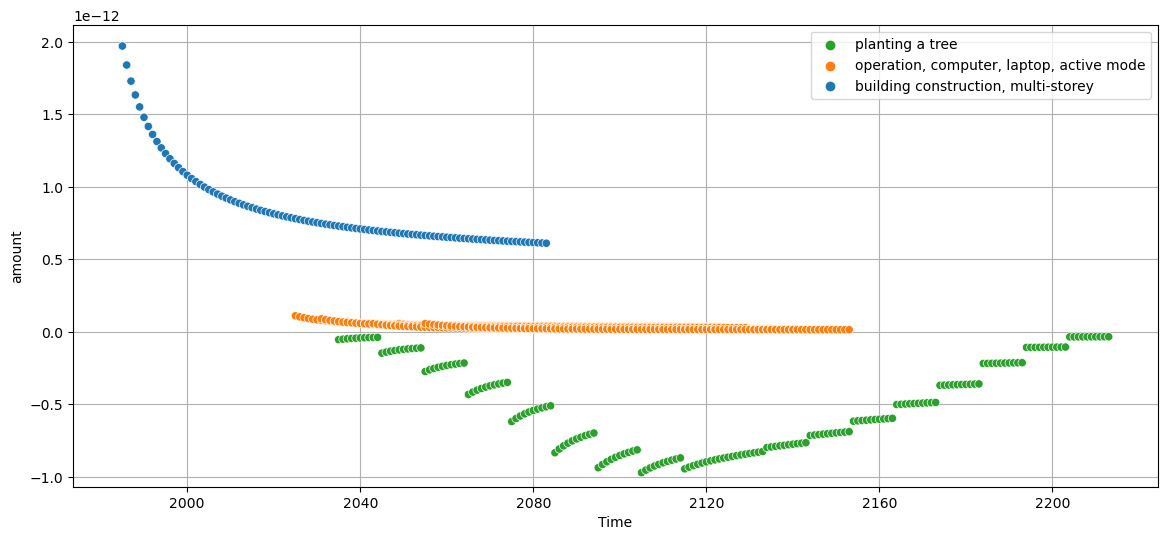

In [21]:
# notice how we don't specify a characterization_function_dict here?
# this triggers the use of some default ones that work with biosphere3! 
# Check the docstrings for more info :) 

tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=100,
)
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

GWP:

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:80: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions from `dynamic_characterization` meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category. You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_function_dict.
  warnings.warn(
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


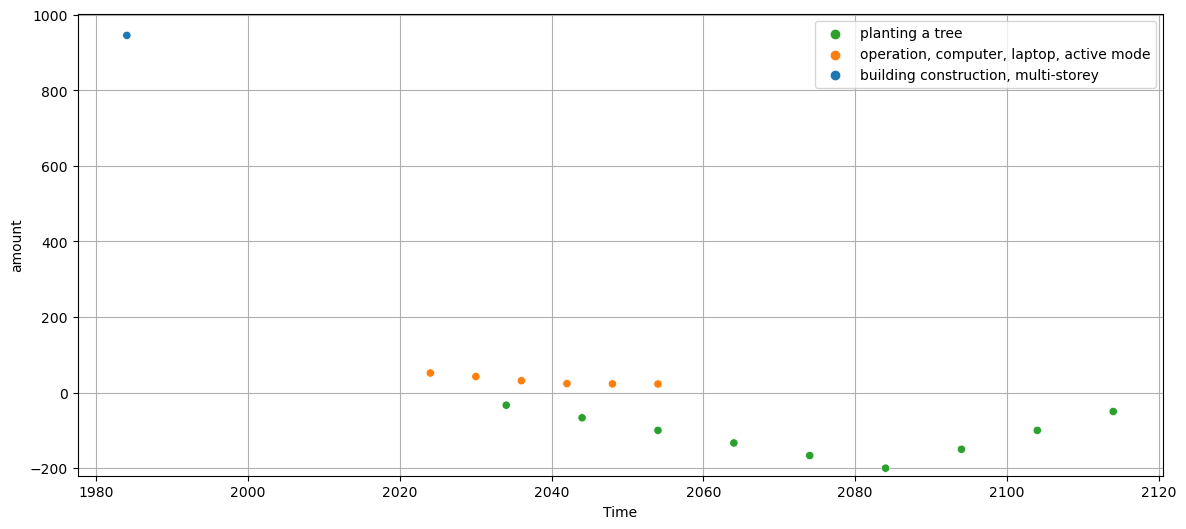

In [22]:
tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=100,
)
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

Prefer waterfall charts?

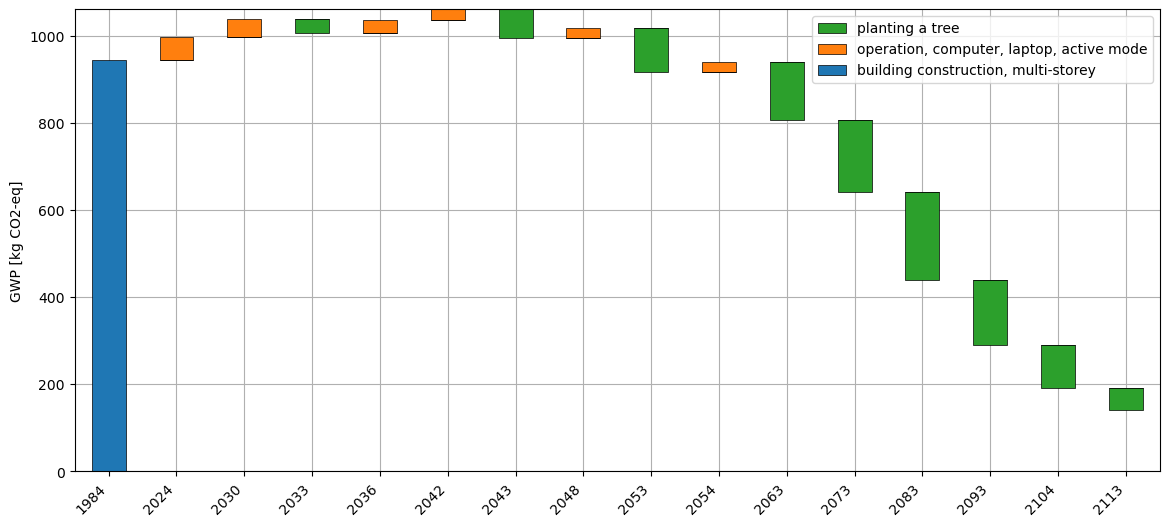

In [23]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall
plot_characterized_inventory_as_waterfall(tlca)